# Imports

In [7]:
import pandas as pd
import geopandas as gpd

import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib.pyplot as plt

import mapclassify as mc

from helper_scripts import utils

# Load data

In [8]:
# Load districtwise map data
map_data = gpd.read_file('../data/nepal_map_data/nepal-districts.geojson')

# Load number of enrollments and teachers data
raw_enrollments_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-primary-school-districtwise.csv')
raw_enrollments_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-lower-secondary-districtwise.csv')
raw_enrollments_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-secondary-districtwise.csv')

raw_teachers_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/primary-teachers-districtwise.csv')
raw_teachers_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/lower-secondary-teachers-districtwise.csv')
raw_teachers_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/secondary-school-teachers-districtwise.csv')

# Preprocess

In [9]:
# rename columns and remove unnecessary aggregate row
# we only need the year and district data
year = '2015'

enrollments_primary = raw_enrollments_primary.rename(columns={'District':'DISTRICT', year:'Enrollments'})[:-1]
enrollments_primary = enrollments_primary[['DISTRICT','Enrollments']]

teachers_primary = raw_teachers_primary.rename(columns={'Region/District':'DISTRICT', year:'Teachers'})[:-1]
teachers_primary = teachers_primary[['DISTRICT','Teachers']]

# calculate the composite measure in a new frame, and add it to the geo data
prelem_ratio_dataframe = pd.merge(enrollments_primary, teachers_primary, how='inner', on='DISTRICT')
prelem_ratio_dataframe['ratio'] = round(prelem_ratio_dataframe['Enrollments']/prelem_ratio_dataframe['Teachers'], 2)

# match the cases and merge with the map data
prelem_ratio_dataframe['DISTRICT'] = prelem_ratio_dataframe['DISTRICT'].str.upper()

final_ratio_data = map_data.merge(prelem_ratio_dataframe, how='inner', on='DISTRICT')

# PLOT IN A MAP!

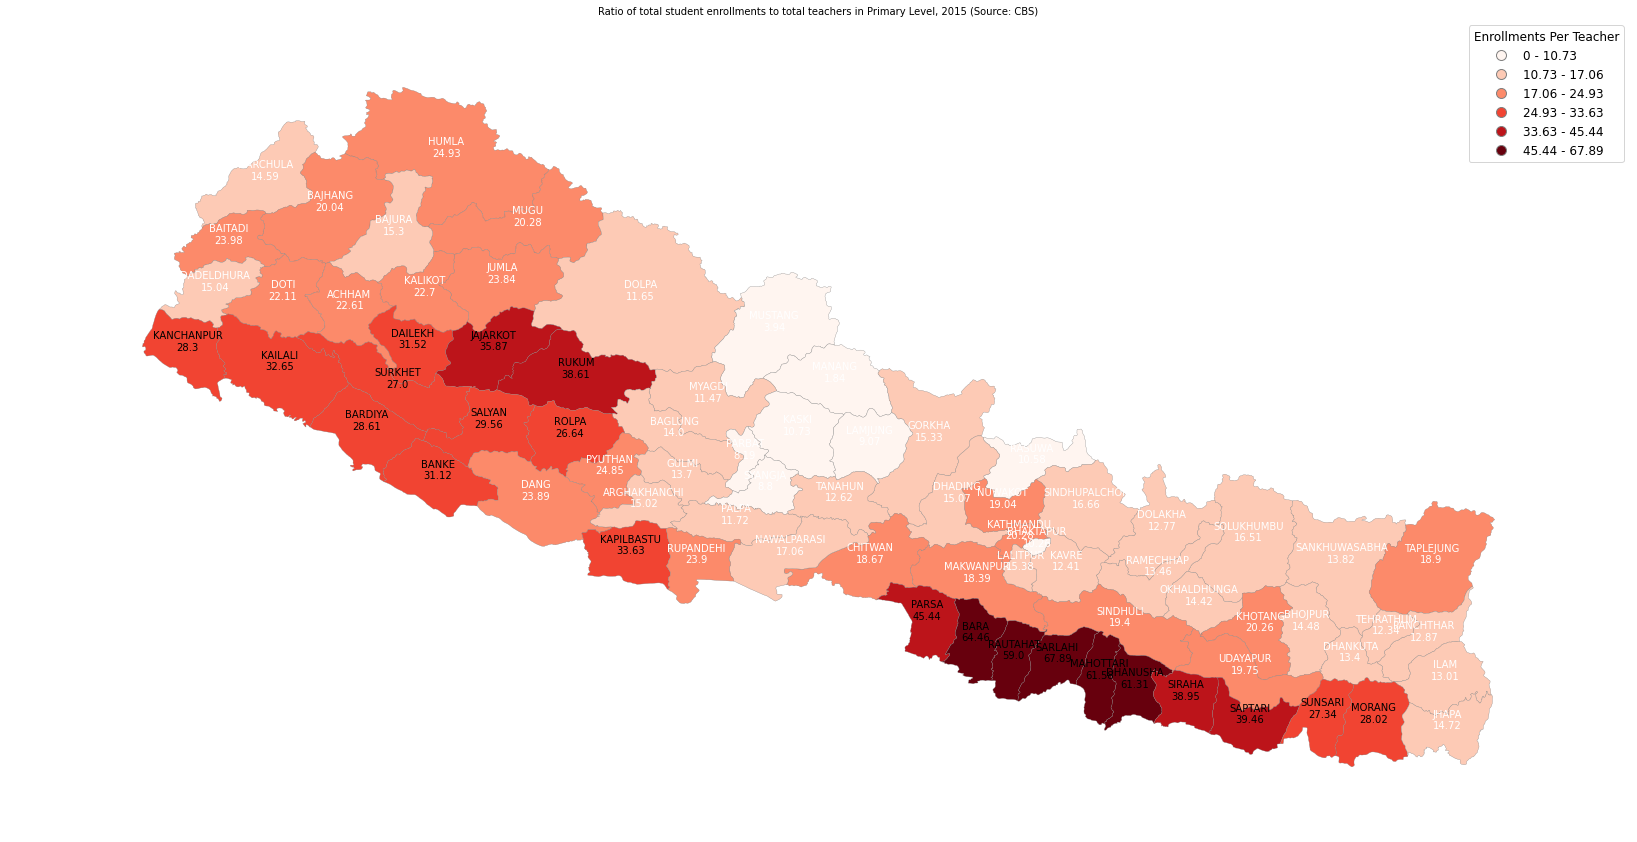

In [10]:
scheme = mc.FisherJenks(final_ratio_data['ratio'], k=6)

ax = gplt.choropleth(
    final_ratio_data, figsize=(30,15),
    hue='ratio', 
    cmap='Reds', linewidth=0.3, edgecolor='gray',
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Enrollments Per Teacher",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

# apply labels to every district so they appear on map
final_ratio_data.apply(utils.annotate_polygons(ax, annotation_field='DISTRICT',annotation_value_field='ratio', threshold=24.94), axis=1)

plt.title("Ratio of total student enrollments to total teachers in Primary Level, 2015 (Source: CBS)", fontdict={"fontsize": 10}, pad=5)
plt.savefig('../visualizations/PrimaryStudentTeacher.svg', bbox_inches='tight')